In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import fits
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

In [2]:
def extract_source(data):
    # Calculate background statistics
    mean, median, std = sigma_clipped_stats(data)
    signal = data - median

    # Define the star finder parameters
    threshold = std*3  # Adjust the threshold as needed
    fwhm = 5  # Adjust the FWHM as needed
    brightest_stars = 10  # Number of stars to find
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold, brightest=brightest_stars, sky=mean, exclude_border=True)

    # Find stars in the data
    sources = daofind(signal)
    return sources, signal

In [3]:
def plot_aperature(data, aperture):
    mask = aperture.to_mask(method='center')
    roi_data = mask.cutout(data)
    plt.imshow(roi_data, cmap='Greys', origin='lower')
    plt.colorbar(label='Intensity')
    plt.show()

In [4]:
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from photutils.centroids import centroid_quadratic
from photutils.profiles import RadialProfile

APERTURE_R = 10

def calc_hfd(signal, aperture):
    mask = aperture.to_mask(method='center')
    roi_data = mask.cutout(signal)
    dist_weighted_flux = 0
    for (y, x), pix in np.ndenumerate(roi_data):
        dist = np.sqrt(y*y+x*x)
        if dist < APERTURE_R:
            dist_weighted_flux += pix * dist

    # total_flux = aperture_photometry(signal, aperture)['aperture_sum'][0]
    total_flux = np.sum(roi_data)
    return dist_weighted_flux / total_flux * 2

def calc_fwhm(signal, aperture):
    xycen = aperture.positions
    edge_radii = np.arange(25)
    rp = RadialProfile(signal, xycen, edge_radii, mask=None)
    fwhm_value = rp.gaussian_fwhm
    # plot_aperature(signal, rp.apertures[-1])
    return fwhm_value

In [5]:
from glob import glob
images = glob('focus_test/manual/*.fits')
images.sort()
images

['focus_test/manual/2023-10-12_22-07-46_L_-15.00_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-07-56_L_-15.00_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-08-04_L_-14.90_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-08-13_L_-14.90_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-08-25_L_-15.00_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-08-41_L_-15.00_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-08-49_L_-14.90_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-08-57_L_-14.90_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-09-06_L_-14.90_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-09-14_L_-14.90_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-09-26_L_-15.00_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-09-33_L_-15.00_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-09-40_L_-14.90_2.00s_g60_0000.fits']

In [7]:
fwhm_curve_dp = []
hfd_curve_dp = []
focuser_positions = []

for img in images:
    hdul = fits.open(img)
    data = hdul[0].data
    current_focus = hdul[0].header['FOCUSPOS']
    sources, signal = extract_source(data)

    x_coords = sources['xcentroid']
    y_coords = sources['ycentroid']
    x,y = list(zip(x_coords, y_coords))[0]

    # Calculate the FWHM for each detected star
    fwhm_values = []
    hfd_values = []

    for x, y in zip(x_coords, y_coords):
        aperture = CircularAperture((x, y), r=APERTURE_R)
        fwhm_value = calc_fwhm(signal, aperture)
        fwhm_values.append(fwhm_value)

        # HFD
        hfd = calc_hfd(signal, aperture)
        hfd_values.append(hfd)
    
    fwhm_values = np.array(fwhm_values)
    hfd_values = np.array(hfd_values)
    mean_fwhm = np.mean(fwhm_values)
    mean_hfd = np.mean(hfd_values)
    fwhm_curve_dp.append(mean_fwhm)
    hfd_curve_dp.append(mean_hfd)
    focuser_positions.append(current_focus)
    print(f'Focus: {current_focus} FWHM: {mean_fwhm} HFD: {mean_hfd}')


Focus: 13695 FWHM: 3.5362879023293727 HFD: 0.24995504547183
Focus: 13720 FWHM: 3.721355450354107 HFD: 0.2974685289160995
Focus: 13745 FWHM: 3.908496528441391 HFD: 0.3723565239345575
Focus: 13770 FWHM: 5.362550479999639 HFD: 0.6788237805346665
Focus: 13820 FWHM: 8.882569137436757 HFD: 1.5777035611759163
Focus: 13645 FWHM: 3.3949519482240076 HFD: 0.18952763253357524
Focus: 13620 FWHM: 3.988128913975961 HFD: 0.2021809629894956
Focus: 13595 FWHM: 5.037383743194988 HFD: 0.3591840033880472
Focus: 13570 FWHM: 6.22355643314642 HFD: 0.31517429705087
Focus: 13545 FWHM: 8.458608474403956 HFD: 1.0884813152453303
Focus: 13520 FWHM: 10.158831853608943 HFD: 2.2867862105955803
Focus: 13495 FWHM: 12.665609036281914 HFD: 2.174804405346097
Focus: 13470 FWHM: 14.209474821223722 HFD: 2.533190987822837


In [8]:
# fit the data with a quadratic
fwhm_fit = np.polyfit(focuser_positions, fwhm_curve_dp, 2)

# predict the minimum value
fwhm_min_value = -fwhm_fit[1] / (2 * fwhm_fit[0])

print(f"FWHM predicted focuser position is {fwhm_min_value:.2f}")

# fit the data with a quadratic
hfd_fit = np.polyfit(focuser_positions, hfd_curve_dp, 2)

# predict the minimum value
hfd_min_value = -hfd_fit[1] / (2 * hfd_fit[0])

print(f"HFD predicted focuser position is {hfd_min_value:.2f}")


FWHM predicted focuser position is 13678.46
HFD predicted focuser position is 13670.96


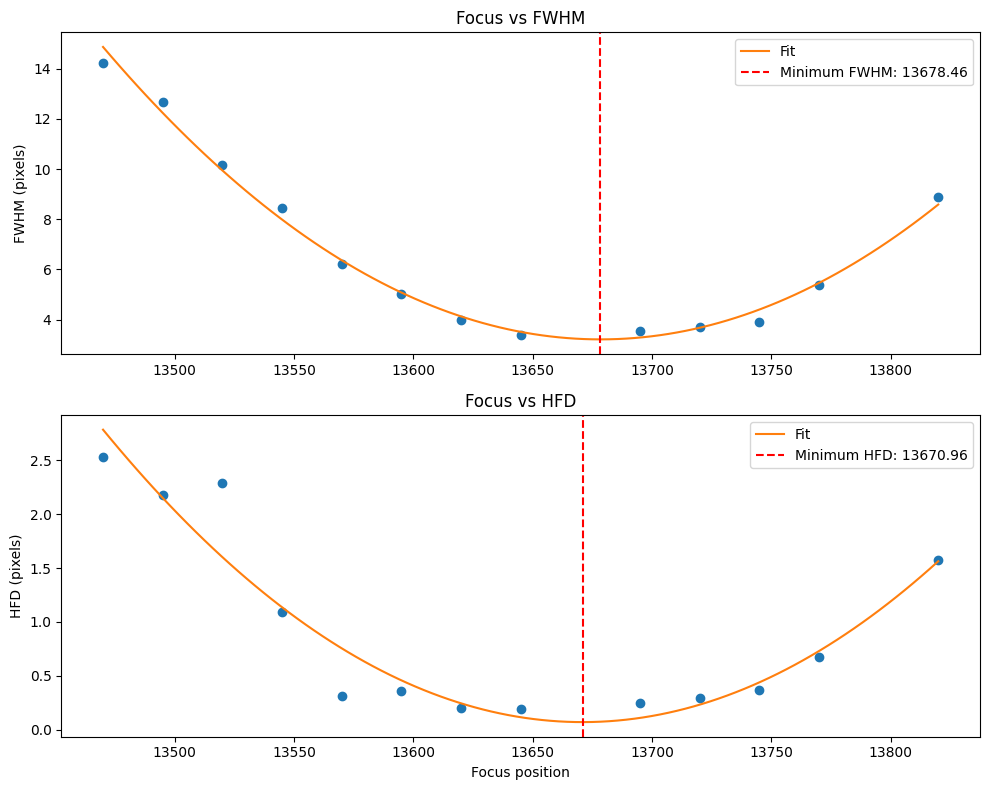

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

x_fit = np.linspace(min(focuser_positions), max(focuser_positions), 100)

# plot FWHM curve and fit
ax1.plot(focuser_positions, fwhm_curve_dp, 'o')
y_fit = np.polyval(fwhm_fit, x_fit)
ax1.plot(x_fit, y_fit, label='Fit')
ax1.set_ylabel('FWHM (pixels)')
ax1.set_title('Focus vs FWHM')

# plot HFD curve and fit
ax2.plot(focuser_positions, hfd_curve_dp, 'o')
y_fit = np.polyval(hfd_fit, x_fit)
ax2.plot(x_fit, y_fit, label='Fit')
ax2.set_xlabel('Focus position')
ax2.set_ylabel('HFD (pixels)')
ax2.set_title('Focus vs HFD')

# mark the minimum value of the fit
fwhm_min_value = -fwhm_fit[1] / (2 * fwhm_fit[0])
ax1.axvline(fwhm_min_value, color='r', linestyle='--', label=f'Minimum FWHM: {fwhm_min_value:.2f}')

hfd_min_value = -hfd_fit[1] / (2 * hfd_fit[0])
ax2.axvline(hfd_min_value, color='r', linestyle='--', label=f'Minimum HFD: {hfd_min_value:.2f}')

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
